**환경 변수 로드**: 첫 번째 모듈의 "Getting setup"을 참조하세요. `dotenv` [문서](https://pypi.org/project/python-dotenv/)는 `../.env` 파일을 찾습니다. 파일을 찾으면 현재 셸의 변수를 덮어쓰며 환경 변수를 로드합니다. 파일을 찾지 못하면 현재 셸의 변수를 사용합니다.

In [43]:
# ⚙️ 프로젝트 환경 설정을 위한 첫 단계입니다.
# 필요한 라이브러리를 가져오고, 노트북의 기본적인 동작 방식을 설정합니다.

import os

from dotenv import load_dotenv

# .env 파일에서 환경 변수를 불러옵니다.
# 🕵️‍♂️ 이 기능 덕분에 API 키와 같은 민감한 정보를 코드에 직접 적지 않고도 안전하게 사용할 수 있어요.
# override=True는 이미 설정된 환경 변수가 있어도 .env 파일의 값으로 덮어쓰겠다는 의미입니다.
load_dotenv(os.path.join("..", ".env"), override=True)

#  Jupyter Notebook의 자동 리로드 기능을 활성화합니다.
# 🔄 이 설정을 해두면 외부 파이썬 파일(.py)을 수정했을 때,
# 노트북 커널을 재시작하지 않아도 변경사항이 바로바로 반영되어 개발이 아주 편해져요!
# %load_ext autoreload는 autoreload 확장 기능을 불러오는 명령어입니다.
%load_ext autoreload
# %autoreload 2는 코드를 실행할 때마다 모든 모듈을 자동으로 리로드하도록 설정합니다.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ReAct 에이전트 생성 - 사전 구축된 버전

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이 과정에서는 [Deep Agent](https://blog.langchain.com/deep-agents/)를 구축할 것입니다. 코드를 크게 단순화하는 LangGraph의 '사전 구축된' 에이전트 추상화를 기반으로 구축할 것입니다. 이 수업에서는 사전 구축된 ReAct 에이전트에 대해 배울 것입니다. 학습할 내용은 다음과 같습니다:
- ReAct 에이전트란 무엇인가
- 우리 구현의 기능과 더 알아볼 수 있는 곳
	- 도구를 사용한 에이전트 구축
	- 그래프, 상태 및 메시지
	- 도구를 사용한 상태 접근 및 수정
	- <span style="font-size:0.8em;">🪝</span> 훅과 구조화된 응답


### ReAct 에이전트란 무엇인가


<img src="./assets/agent.png"
	 style="float:left; max-width:300px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1250px;">
	
LangGraph의 오픈소스 `create_react_agent` ([여기 참조](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent)) 추상화를 사용할 것입니다. **ReAct 에이전트**는 "추론과 행동"(ReAct) 프레임워크를 사용하여 사고의 연쇄(CoT) 추론과 외부 도구 사용을 결합하는 AI 에이전트입니다. 이는 [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629) 논문으로 유명해졌습니다.

이 에이전트는 세 가지 구성 요소로 이루어져 있습니다: 대형 언어 모델(LLM), 사용할 수 있는 도구 세트, 지침을 제공하는 프롬프트입니다.

LLM은 루프에서 작동합니다. 각 반복에서 사용 가능한 도구 목록을 포함한 컨텍스트를 검토하고, 도구를 호출해야 하는지 결정합니다. 호출할 도구를 선택하고 도구 호출을 형성합니다. 이것은 실행을 위해 도구 노드로 전송됩니다. 도구 노드는 도구를 실행하고 결과(관찰)를 LLM으로 다시 보냅니다. LLM은 관찰을 받고 그 관찰을 사용하여 다음 행동을 결정합니다. 에이전트가 더 이상 도구를 호출할 필요가 없다고 결정할 때까지 루프가 계속됩니다.
</div>

<div style="clear:both;"></div>

>  참고: `create_react_agent`는 곧 출시될 V1로 이동 중입니다! LangChain에 포함되며 이름이 간단히 `create_agent`로 변경됩니다.

### LangGraph 사전 구축된 `create_react_agent`의 주요 기능

`create_react_agent` 추상화와 함께 제공되는 기능들입니다. 이 과정에서 모든 기능을 사용하지는 않지만, 우리 과정을 구축하기 위해 `create_react_agent` 사용을 동기부여합니다 (더 알아보기 [여기](https://langchain-ai.github.io/langgraph/agents/overview/#what-is-an-agent)):

- [메모리 통합](../how-tos/memory/add-memory.md): _단기_(세션 기반) 및 _장기_(세션 간 지속) 메모리에 대한 네이티브 지원으로 챗봇과 어시스턴트의 상태 유지 동작을 가능하게 합니다.
- [인간 중심 루프 제어](../concepts/human_in_the_loop.md): 실행이 인간의 피드백을 기다리기 위해 _무기한_ 일시 중지될 수 있습니다—실시간 상호작용에 제한된 웹소켓 기반 솔루션과 달리. 이를 통해 워크플로우의 어느 지점에서든 비동기 승인, 수정 또는 개입이 가능합니다.
- [스트리밍 지원](../how-tos/streaming.md): 에이전트 상태, 모델 토큰, 도구 출력 또는 결합된 스트림의 실시간 스트리밍.
- [배포 도구](../tutorials/langgraph-platform/local-server.md): 인프라 없는 배포 도구를 포함합니다. [**LangGraph Platform**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)은 테스트, 디버깅 및 배포를 지원합니다.
  - [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/): 워크플로우를 검사하고 디버깅하기 위한 시각적 IDE.
  - [LangSmith](https://smith.langchain.com/): 추적 및 평가 도구.
  - 프로덕션을 위한 여러 [배포 옵션](https://langchain-ai.github.io/langgraph/concepts/deployment_options.md) 지원.

`create-react-agent`는 매우 정교하며 많은 입력 형식을 받아들이고 많은 사용자 정의를 허용합니다. 간단한 에이전트-도구 루프가 될 수 있거나, 사전/사후 훅 및/또는 구조화된 출력으로 사용자 정의할 수 있습니다.

<div style="display:flex; justify-content:center; align-items:flex-end; gap:40px;">

  <figure style="margin:0; text-align:center; width:250px;">
	<img src="./assets/simple_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
	<figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">간단한 에이전트</figcaption>
  </figure>

  <figure style="margin:0; text-align:center; width:250px;">
	<img src="./assets/complex_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
	<figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">복잡한 에이전트</figcaption>
  </figure>

</div>
</div>
<br>

이 과정에서는 간단한 형식을 사용할 것입니다—과정 후반에 하위 에이전트 <span style="font-size:20px;">🤖 🤖 🤖</span>를 추가할 것입니다!   

  

#### 도구를 사용한 에이전트 구축

시작하기 위해 간단한 계산기 도구를 사용한 에이전트를 생성해보겠습니다. 구성 방식을 확인한 후 더 자세한 내용을 살펴보겠습니다.


In [44]:
# 🤖 에이전트에게 '계산'이라는 특별한 능력을 부여해 줄 도구를 만들어 보겠습니다.
# 이 도구는 에이전트가 스스로 계산을 수행할 수 있게 해주는 핵심 기능이에요.

from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


# @tool 데코레이터는 이 함수가 LLM이 사용할 수 있는 '도구'임을 알려주는 마법 같은 표시입니다! ✨
@tool
def calculator(
	# 어떤 연산을 수행할지 명확하게 지정합니다. ('add', 'subtract', 'multiply', 'divide' 중 하나만 가능!)
	operation: Literal["add","subtract","multiply","divide"],
	# 첫 번째 숫자 (정수 또는 실수)
	a: Union[int, float],
	# 두 번째 숫자 (정수 또는 실수)
	b: Union[int, float],
) -> Union[int, float]:
	"""두 개의 입력을 받는 계산기 도구.

	Args:
		operation (str): 수행할 연산 ('add', 'subtract', 'multiply', 'divide').
		a (float or int): 첫 번째 숫자.
		b (float or int): 두 번째 숫자.
		
	Returns:
		result (float or int): 연산 결과.
	Example:
		나누기: result   = a / b
		빼기: result = a - b
	"""
	# 🧐 0으로 나누는 경우를 대비한 예외 처리! 에이전트가 오류에 빠지지 않도록 방지해줘요.
	if operation == 'divide' and b == 0:
		return {"error": "0으로는 나눌 수 없어."}

	# 실제 계산을 수행하는 부분입니다.
	if operation == 'add':
		result = a + b
	elif operation == 'subtract':
		result = a - b
	elif operation == 'multiply':
		result = a * b
	elif operation == 'divide':
		result = a / b
	else: 
		result = "알 수 없는 연산이야."
	return result


/var/folders/lm/k8lvspp966gd5cw9m_b997hh0000gn/T/ipykernel_15743/2489365911.py:30: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(
E0000 00:00:1760709118.547889 1253049 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


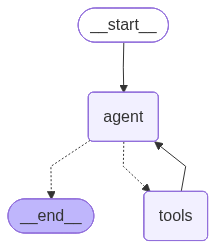

In [45]:
# 🧠 이제 본격적으로 ReAct 에이전트를 만들어 볼 시간입니다!
# LLM 모델, 우리가 만든 도구, 그리고 에이전트의 역할을 정의하는 시스템 프롬프트를 하나로 합치는 과정이에요.

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

# ReAct 에이전트를 직접 생성합니다.
# 이 부분이 바로 에이전트의 핵심 구성 요소를 정의하는 곳입니다.
# --------------------------------------------------------------------------------------

# 📜 시스템 프롬프트: 에이전트에게 정체성과 목표를 부여하는 지시문입니다.
# "너는 계산기를 아주 잘 다루는 산수 도우미야" 라고 역할을 정해주는 거죠.
SYSTEM_PROMPT = "너는 계산기 사용에 능숙한 산수 도우미야."

# 🤖 사용할 LLM 모델을 초기화합니다. 에이전트의 '두뇌' 역할을 담당해요.
# 여기서는 Google의 Gemini 2.5 Flash 모델을 사용하고, temperature=0.0으로 설정하여
# 일관성 있고 예측 가능한 답변을 생성하도록 합니다.
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# 🛠️ 에이전트가 사용할 도구 목록을 지정합니다.
# 위에서 만든 `calculator` 함수를 리스트에 담아 전달해요.
# 여러 도구가 있다면 여기에 모두 추가하면 됩니다.
tools = [calculator]

# ✨ 드디어 에이전트 생성!
# `create_react_agent` 함수에 모델, 도구, 시스템 프롬프트를 전달하여 에이전트를 만듭니다.
agent = create_react_agent(
	model,
	tools,
	prompt=SYSTEM_PROMPT,
	#state_schema=AgentState,  # 기본값으로 사용되므로 주석 처리
).with_config(
    # recursion_limit은 에이전트가 최대 몇 단계까지 작업을 수행할 수 있는지를 제한하는 설정입니다.
    # 🔄 너무 깊은 루프에 빠지는 것을 방지해줘요.
    {"recursion_limit": 20}
)

# 📊 생성된 에이전트의 구조를 시각적으로 확인해볼까요?
# 에이전트가 어떤 흐름으로 작동하는지 다이어그램으로 보여줍니다.
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### 그래프, 상태 및 메시지
곧 에이전트를 실행할 것이지만, 그래프에 대해 조금 더 자세히 살펴보겠습니다.
세부 사항을 보고 싶다면 `create_react_agent`를 구현하는 코드를 [여기](https://github.com/langchain-ai/langgraph/blob/c37c9cbab3287f0988fabe2b853569a23960e3db/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에서 확인할 수 있습니다. 이것의 간단한 버전을 직접 구축해보고 싶다면 [Foundation: Introduction to LangGraph, Module 1, Lesson 6, Agent](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)를 확인해보세요.

**에이전트 정의**: 위에서 했던 것처럼 에이전트를 정의할 때 제공하는 것들: 모델, 하나 이상의 도구, "시스템" 프롬프트, 그리고 기본적으로 <a href="https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py#L62-L69">
  <code style="color:#0366d6;">AgentState</code>
</a>인 상태 스키마로 주로 메시지 목록입니다. ([호출 세부사항은 여기](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent))
내부적으로 이것은 위에 표시된 LangGraph 그래프를 정의하고 컴파일하는 것입니다. 중요한 세부사항은 도구 노드가 또 다른 사전 구축된 항목인 `ToolNode`라는 것입니다. [여기](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/tool_node.py#L239-L293)에 설명되어 있습니다. 도구 노드는 LLM의 메시지에서 식별된 모든 도구를 실행하고 결과를 반환합니다.

**에이전트 호출:** 
에이전트를 호출하고 결과를 확인해보겠습니다!

In [46]:
# 🚀 이제 우리가 만든 에이전트에게 실제 임무를 줘볼까요?
# "3.1 * 4.2가 뭐야?" 라는 질문을 던져서 에이전트가 어떻게 반응하는지 살펴봅시다.

# 사용 예시
result1 = agent.invoke(
	{
		# `messages`는 에이전트와 주고받는 대화의 기록입니다.
		# 사용자의 질문은 'user' 역할로 전달됩니다.
		"messages": [
			{
				"role": "user",
				"content": "3.1 * 4.2는 몇이야?",
			}
		],
	}
)

# 💬 에이전트의 응답 결과를 보기 쉽게 정리해서 출력합니다.
# `format_messages` 유틸리티 함수가 대화 내용을 예쁘게 보여줄 거예요.
format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2는 몇이야?                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 4.2,                                                                                                     │
│   "a": 3.1                                                                                                      │
│ }                                                                                                               │
│    ID: 3c25cc52-f574-4f8a-a46e-0210fef067d4                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02입니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**에이전트 호출:** 
시퀀스 다이어그램은 모델이 호출될 때 일어나는 일을 보는 좋은 방법입니다.

<div style="display:none">
	향후를 위해 mermaid 코드가 여기에 저장됨
```mermaid
sequenceDiagram
	participant U as User
	participant A as LLM
	participant T as Tools
	Note over A: System message<br/>"You are a helpful assistant..."
	U->>A: Initial input,<br/>"What is 3.1 * 4.2?"
	loop while tool_calls present
		A->>T: AIMessage(id="call_123", tool_calls=[...])
		T-->>A: ToolMessage(tool_call_id="call_123", content="xx")
	end
	A->>U: Return final state
```
</div> 

<img src="./assets/agent_sequence_diagram.png"
	 style="float:left; max-width:500px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1100px;">
예시에서 사용자 입력은 "What is 3.1 * 4.2?"입니다. 이것이 시스템 프롬프트와 도구 설명과 함께 LLM으로 전송됩니다.  
<br/>
<p style="margin-bottom:0; margin-top:5px;">LLM은 계산기 도구를 호출해야 한다고 결정합니다. <br/> `messages`에 `AIMessage`를 추가합니다:</p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:0;">
<code class="language-python">AIMessage(
	content="",
	tool_calls=[{"id": "call_123",
				 "name": "calculator",
				 "args": {"a": 3.1, "b": 4.2, "operation": "multiply"}}])</code></pre>   
</code></pre>
<br/>
<p style="margin-bottom:0;">도구 노드는 AIMessage를 받고 모든 도구 호출을 처리합니다. tool_call_ids를 추적합니다. `messages`에 ToolMessage로 응답합니다: </p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:10px;">
<code class="language-python">ToolMessage(
	content="13.02",		 # 도구 실행의 결과
	tool_call_id="call_123")  # AIMessage.tool_calls의 id와 일치
</code></pre>
LLM은 `messages`의 응답을 검토하고 완료되었다고 결정하며 사용자에게 `AIMessage`를 형성합니다.

</div>

<div style="clear:both;"></div>

[LangSmith의 추적](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r)을 살펴보겠습니다. 주목할 점들:
- LLM 호출의 메타데이터에서 'calculator' 도구 설명을 볼 수 있습니다.
- 모델의 응답은 인수를 포함한 도구 호출입니다.
- LLM의 최종 호출에서 도구 노드가 제공한 일치하는 tool_call_id를 확인하세요.

#### 직접 시도해보기
잠시 시간을 내어 직접 시도해보세요. 쿼리를 실행하고 LangSmith에서 확인하여 기대와 일치하는지 확인하세요. 계산기를 확장해보세요—예를 들어 제곱 함수를 추가해보세요.

In [47]:
# ✨ 이제 여러분 차례입니다! 자유롭게 질문을 던져보세요!
# "What is ...?" 부분에 원하는 계산식을 넣어 에이전트의 능력을 시험해보세요.
# 예를 들어, "123 + 456은 몇이야?" 또는 "99 / 3은 몇이야?" 와 같이 질문할 수 있습니다.

# 직접 시도해보기
result = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "몇이야?",
			}
		],
	}
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 몇이야?                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 무엇을 계산할지 알려주시면 제가 도와드릴 수 있습니다.                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### 도구 내에서 상태 접근 및 수정
#### 상태
LangGraph의 좋은 기능 중 하나는 상태입니다. 그래프는 각 노드가 그래프 지속 시간 동안 사용할 수 있고 장기 저장소에 지속될 수 있는 타입이 지정된 데이터 구조를 가집니다. 이를 사용하여 노드 간에 공유할 정보를 저장하고, 그래프를 디버깅하며, 장기 실행 그래프를 이전 시간으로 재설정할 수 있습니다.

그래프에 대한 상태를 정의할 때 데이터 타입과 '리듀서' 함수를 정의합니다. 리듀서는 정보가 해당 요소에 어떻게 추가되는지 설명합니다. 작업이 병렬로 실행되고 상태를 동시에 업데이트하는 여러 노드에 매핑될 때 특히 유용합니다.

이 예제에서는 기본 `AgentState`가 사용되었습니다. 이것은 [langgraph.prebuilt.chat_agent_executor](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에 정의되어 있습니다.   

```python
	class AgentState(TypedDict):
		"""The state of the agent."""
		messages: Annotated[Sequence[BaseMessage], add_messages]
		remaining_steps: NotRequired[RemainingSteps]
```
		
- `messages`는 LLM과 주고받는 메시지를 포함하는 [langchain_core](https://github.com/langchain-ai/langchain/blob/088095b663993b1e53cf616e1ca487d1739b0d71/libs/core/langchain_core/messages/base.py)에 정의된 `BaseMessage` 목록입니다.
	- typing.Annotated를 사용하면 타입 힌트에 임의의 메타데이터를 첨부할 수 있습니다. 구문: Annotated[Type, metadata1, metadata2, ...] 
- `add_messages` 리듀서는 새 메시지를 메시지 목록 끝에 추가합니다.  
- `remaining_steps`는 그래프의 단계를 추적합니다. 이것이 `recursion_limit`으로 초기화되는 것을 볼 수 있지만 그래프에 의해 추적되며 사용자에게는 보이지 않습니다.  
빠르게 살펴보겠습니다.

In [48]:
# 🕵️‍♂️ 에이전트의 머릿속을 들여다볼 시간입니다!
# 에이전트가 작업을 완료한 후, 그 과정이 담긴 `state` 객체를 자세히 살펴보겠습니다.
# `messages` 필드에는 사용자의 질문부터 시작해서 LLM의 추론, 도구 호출, 그리고 최종 답변까지 모든 대화 기록이 담겨있어요.

from IPython.display import JSON
from langchain_core.messages import messages_to_dict

# result1 객체에 저장된 메시지들을 JSON 형식으로 깔끔하게 출력합니다.
# 이 기록을 통해 에이전트가 어떤 생각의 흐름(Chain-of-Thought)을 거쳐 답변에 도달했는지 알 수 있습니다.
JSON({"messages": messages_to_dict(result1["messages"])})

<IPython.core.display.JSON object>

#### 사용자 정의 상태
수행된 모든 연산의 목록을 유지하도록 계산기를 확장해보겠습니다. 이를 위해 상태에 목록을 추가하고 상태를 목록에 추가하는 리듀서 함수가 필요합니다. 목록이나 연산이 비어 있는 경우를 안전하게 처리합니다.

In [49]:
# 🏗️ 에이전트의 기억력을 업그레이드해 봅시다!
# 기본 `AgentState`를 상속받아 우리가 원하는 정보를 추가로 저장할 수 있는 `CalcState`를 만듭니다.
# 여기서는 에이전트가 수행한 모든 연산 기록을 `ops`라는 리스트에 저장해 볼 거예요.

from langgraph.prebuilt.chat_agent_executor import AgentState


# `reduce_list` 함수는 두 개의 리스트를 안전하게 합쳐주는 역할을 합니다.
# 🤝 상태를 업데이트할 때, 기존 연산 기록(left)과 새로운 연산 기록(right)을 합쳐서
# 하나의 리스트로 만들어줍니다. None 값이 들어와도 오류 없이 처리해줘서 안정적이에요.
def reduce_list(left: list | None, right: list | None) -> list:
	"""두 리스트를 안전하게 결합하며, 입력 중 하나 또는 둘 다 None일 수 있는 경우를 처리합니다.

	Args:
		left (list | None): 결합할 첫 번째 리스트 또는 None.
		right (list | None): 결합할 두 번째 리스트 또는 None.

	Returns:
		list: 두 입력 리스트의 모든 요소를 포함하는 새 리스트.
			   입력이 None이면 빈 리스트로 처리됩니다.
	"""
	if not left:
		left = []
	if not right:
		right = []
	return left + right

# AgentState를 상속받아 CalcState를 정의합니다.
class CalcState(AgentState):
	"""그래프 상태(Graph State)."""
	# `ops` 필드를 추가하여 연산 기록을 문자열 리스트로 저장합니다.
	# `Annotated`를 사용하여 `ops` 필드가 업데이트될 때 `reduce_list` 함수를 사용하도록 지정합니다.
	# 📝 이렇게 하면 에이전트가 계산을 수행할 때마다 연산 내역이 자동으로 `ops` 리스트에 차곡차곡 쌓이게 됩니다.
	ops: Annotated[List[str], reduce_list]


#### 상태 접근 
이제 업데이트를 포함하도록 계산기를 확장할 수 있습니다. 이것이 문제를 강조합니다! 이제 상태가 우리 계산기 도구의 인수입니다. 
<img src="./assets/state_arg_diagram.png" width="800" style="display:block; margin-left:0;">
다이어그램에서 명확한 것은 LLM이 도구 호출을 생성하는 임무를 맡고 있지만 컨텍스트에 그것이 없기 때문에 `state` 인수를 형성할 수 없다는 것입니다!  
해결책은 LLM 이후에 **상태를 주입**하는 것입니다.
<img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;"> 

<div style="margin:0; padding:0">
  <p style="margin:0;">이것은 아래에 표시된 <code>InjectedState</code> 어노테이션으로 달성됩니다.</p>
  <pre style="font-size:0.90em; margin:0; padding-top:0;">
<code class="language-python">	@tool
	def calculator_wstate(
		operation: Literal["add","subtract","multiply","divide"],
		a: Union[int, float],
		b: Union[int, float],
		<span style="background:#fff3a3; padding:0 2px;">state: Annotated[CalcState, InjectedState],</span>  # ← LLM에 전송되지 않음
		<span style="background:#fff3a3; padding:0 2px;">tool_call_id: Annotated[str, InjectedToolCallId],</span>  # ← LLM에 전송되지 않음
	) -> Union[int, float]:
</code></pre>
<p style="margin:0; padding-top:4px;">
	이것은 LLM에 제공된 설명에서 <code>state</code>를 제거하고 <code>ToolNode</code>에서 도구를 호출할 때 주입합니다. <code>tool_call_id</code>도 포함됩니다. 이것은 다음 섹션에서 설명됩니다.
  </p>
</div>

#### 상태 업데이트
도구는 일반적으로 상태의 `messages` 필드에 포함된 `ToolMessage`에서 LLM에 관찰을 반환한다는 것을 기억할 수 있습니다. 상태의 추가 멤버를 업데이트하기 위해 이 업데이트를 확장하고 싶습니다. 아래 반환에서처럼 `Command`를 사용하여 수행됩니다. 
```python
	return Command(
		update={
			"ops": ops,
			"messages": [
				ToolMessage(f"{result}", tool_call_id=tool_call_id)
			]})
```
`ToolMessage`를 생성하려면 `tool_call_id`가 필요하다는 점에 유의하세요.

In [50]:
# 🔧✨ 상태(State)를 읽고 쓸 수 있는 업그레이드된 계산기 도구입니다!
# 이 도구는 계산 기능에 더해, 에이전트의 상태(`CalcState`)를 직접 조작하는 능력까지 갖췄어요.

# `@tool` 데코레이터로 이 함수가 도구임을 다시 한번 알려줍니다.
@tool
def calculator_wstate(
	operation: Literal["add","subtract","multiply","divide"],
	a: Union[int, float],
	b: Union[int, float],
	# 💡 중요! `InjectedState`를 사용하면 LLM에게는 이 `state` 인자를 숨긴 채,
	# 도구가 실행되는 시점에 현재 그래프의 상태(`CalcState`)를 몰래 주입받을 수 있습니다.
	# 즉, LLM은 계산에만 집중하고, 상태 관리는 도구가 알아서 처리하게 되는 거죠.
	state: Annotated[CalcState, InjectedState],   # LLM에게 전송되지 않음
	# `InjectedToolCallId`는 현재 도구 호출의 고유 ID를 주입받기 위해 사용됩니다.
	# 이 ID는 나중에 `ToolMessage`를 생성하여 상태를 업데이트할 때 필요해요.
	tool_call_id: Annotated[str, InjectedToolCallId] # LLM에게 전송되지 않음
) -> Union[int, float]:
	"""두 개의 입력을 받는 계산기 도구.

	Args:
		operation (str): 수행할 연산 ('add', 'subtract', 'multiply', 'divide').
		a (float or int): 첫 번째 숫자.
		b (float or int): 두 번째 숫자.
		
	Returns:
		result (float or int): 연산 결과.
	Example:
		나누기: result   = a / b
		빼기: result = a - b
	"""
	if operation == 'divide' and b == 0:
		return {"error": "0으로는 나눌 수 없어."}

	# 계산 수행
	if operation == 'add':
		result = a + b
	elif operation == 'subtract':
		result = a - b
	elif operation == 'multiply':
		result = a * b
	elif operation == 'divide':
		result = a / b
	else: 
		result = "알 수 없는 연산이야."
		
	# 📝 이번 계산에 대한 기록을 생성합니다. (예: "(multiply, 3.1, 4.2),")
	ops = [f"({operation}, {a}, {b})," ]
	
	# `Command`를 사용하여 상태를 업데이트합니다!
	# `ops` 필드에는 새로운 연산 기록을 추가하고,
	# `messages` 필드에는 계산 결과를 담은 `ToolMessage`를 추가하여
	# LLM에게 작업 결과를 알려줍니다.
	return Command(
		update={
			"ops": ops,
			"messages": [
				ToolMessage(f"{result}", tool_call_id=tool_call_id)
			],
		}
	)



In [51]:
# 🤖✨ 업그레이드된 도구와 상태로 새로운 에이전트를 만듭니다!
# 이전 에이전트와 구성은 거의 같지만, 이제는 `calculator_wstate` 도구와
# 사용자 정의 상태인 `CalcState`를 사용한다는 점이 핵심적인 차이입니다.

SYSTEM_PROMPT = "너는 계산기 사용에 능숙한 산수 도우미야."

model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# 🛠️ 이제는 새로운 도구인 `calculator_wstate`를 사용합니다.
tools = [calculator_wstate]  # 새로운 도구

# 에이전트 생성
agent = create_react_agent(
	model,
	tools,
	prompt=SYSTEM_PROMPT,
	# 💡 `state_schema`에 우리가 직접 만든 `CalcState`를 지정해줍니다.
	# 이제 에이전트는 대화 기록(`messages`) 뿐만 아니라 연산 기록(`ops`)도 함께 관리하게 됩니다.
	state_schema=CalcState,  # 상태 스키마 정의
).with_config({"recursion_limit": 20})  # recursion_limit은 에이전트가 실행할 최대 단계 수를 제한합니다.


/var/folders/lm/k8lvspp966gd5cw9m_b997hh0000gn/T/ipykernel_15743/2617639524.py:13: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(
E0000 00:00:1760709122.696360 1253049 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [52]:
# 🚀 업그레이드된 에이전트의 성능을 테스트해봅시다!
# 이전과 동일한 질문을 던져서 어떻게 작동하는지, 그리고 상태가 어떻게 기록되는지 살펴볼게요.

# 사용 예시
result2 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "3.1 * 4.2는 몇이야?",
			}
		],
	}
)

format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2는 몇이야?                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 4.2,                                                                                                     │
│   "a": 3.1                                                                                                      │
│ }                                                                                                               │
│    ID: 3136d0bc-6562-4df1-b808-45960cc5391d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02입니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [53]:
# 📊✨ 결과를 확인해볼까요?
# 이제 에이전트의 응답(`result2`)에는 대화 기록(`messages`) 뿐만 아니라,
# 우리가 새롭게 추가한 연산 기록(`ops`) 필드도 포함되어 있습니다!
# `ops` 필드에 `(multiply, 3.1, 4.2)` 와 같은 기록이 잘 남아있는지 확인해보세요.

# 이제 응답에 ops 필드가 포함된 것을 주목하세요.
JSON(result2)

<IPython.core.display.JSON object>

한 가지 더 시도해보겠습니다. 이 예제에서 이중 도구 호출에 주의하세요. 도구 노드는 이들을 병렬로 실행합니다.

In [54]:
# 🧠 이번엔 좀 더 복잡한 계산에 도전해볼까요?
# 에이전트가 여러 단계의 계산(곱셈 2번, 덧셈 1번)을 순서대로 처리하고,
# 모든 연산 과정을 `ops`에 정확하게 기록하는지 확인해보겠습니다.

# 사용 예시
result3 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "3.1 * 4.2 + 5.5 * 6.5는 몇이야?",
			}
		],
	}
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2 + 5.5 * 6.5는 몇이야?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 4.2,                                                                                                     │
│   "a": 3.1                                                                                                      │
│ }                                                                                                               │
│    ID: a050c580-a135-46ce-b13e-64faea5da92e                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 6.5,                                                                                                     │
│   "a": 5.5                                                                                                      │
│ }                                                                                                               │
│    ID: 90cd4271-5bfd-4df4-8357-b3eec06a380a                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2는 13.02이고 5.5 * 6.5는 35.75입니다. 두 숫자를 더하면 48.77이 됩니다.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [55]:
# 🧐 최종 결과를 분석해봅시다.
# `result3`의 `ops` 필드를 보면, 에이전트가 수행한 모든 계산 단계가
# 순서대로 차곡차곡 쌓여있는 것을 확인할 수 있습니다.
# 이를 통해 에이전트가 어떤 과정을 거쳐 최종 답을 도출했는지 명확하게 파악할 수 있죠!
JSON(result3)

<IPython.core.display.JSON object>

In [56]:
# 🧑‍🔬 이제 여러분이 직접 실험해볼 시간입니다!
# "Create an example of your own?" 대신 원하는 계산 문제를 자유롭게 만들어보세요.
# 에이전트가 복잡한 문제도 잘 해결하는지, 연산 기록은 정확히 남기는지 등을 확인하며
# 배운 내용을 복습하고 응용하는 재미를 느껴보세요!

# 사용 예시 - 직접 만들어보기
result4 = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "직접 예시를 만들어줄래?",
			}
		],
	}
)

format_messages(result4["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 직접 예시를 만들어줄래?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 네, 물론이죠! 덧셈을 해볼게요.                                                                                  │
│                                                                                                                 │
│ 10과 5를 더하면 얼마일까요?                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "b": 5,                                                                                                       │
│   "a": 10                                                                                                       │
│ }                                                                                                               │
│    ID: df97edd9-50be-4483-a150-88d4b99d3f22                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 15                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 네, 10 더하기 5는 15입니다.                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## <span style="font-size:0.8em;">🪝</span> 훅과 구조화된 응답

<table>
<tr>
<td style="width:300px;">
  <img src="./assets/complex_agent.png" style="max-width:100%; height:auto;">
</td>
<td>
  <code>create_react_agent</code>는 많은 추가 기능이 있습니다.  
  이 과정에서는 이들을 사용하지 않을 것이므로 여기서 설명만 하고 탐색은 다른 과정으로 남겨두겠습니다. 

  - 참고로 `create_react_agent` 호출 정의는 [여기](https://langchain-ai.github.io/langgraph/reference/agents/#:~:text=of%20the%20agent.-,create_react_agent,-%C2%B6)에 있습니다.

  - 사전 훅(pre-hook): 에이전트 노드 이전에 노드를 삽입합니다. `state`에 접근할 수 있습니다. 이는 메시지를 요약하거나 압축하여 관리하는 데 자주 사용됩니다. 자세한 내용은 [여기](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-manage-message-history/#keep-the-original-message-history-unmodified:~:text=to%20the%20LLM.-,def%20pre_model_hook(state)%3A,-trimmed_messages%20%3D%20trim_messages)를 참조하세요.
  - 사후 훅(post-hook): LLM 호출 이후, 도구 호출 이전에 노드를 삽입합니다. 이는 인간의 개입, 가드레일, 검증 또는 기타 후처리를 구현하는 데 유용합니다.
  - response_format: `END` 이전에 노드를 추가합니다. 이는 LLM.with_structured_output을 호출하고 출력은 주어진 스키마와 일치하도록 형식화되어 'structured_response' 상태 키에 반환됩니다.
</td>
</tr>
</table> 

 